In [1]:
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
import time
import random
from TTHelperFuncts import *

In [2]:
# computeSiteAssignmentLSALP
   # this linear Program takes the cluster bounds and the matrix of distances that were already computed and generates
   # a linear program to minimize the the distance sums taking the cluster bounds into account
def computeSiteAssignmentLSALP(upperBound, lowerBound, distances):
    m = Model("assignment")
    m.Params.Method = 0
    m.Params.Presolve = 0
    m.Params.LogToConsole = 0
    #variables
    x = m.addVars(np.size(distances, axis = 0), np.size(distances, axis=1),lb = 0.0, ub = 1.0, name = "x") #vtype=GRB.BINARY, name="x")
    #objective
    m.setObjective(quicksum(x[i,j]*distances[i,j] for i in range(np.size(distances, axis = 0)) 
                                                                 for j in range(np.size(distances, axis=1))), GRB.MINIMIZE)
    #constraints
    for k in range(np.size(distances, axis = 0)):
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) <= upperBound[k])
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) >= lowerBound[k])
    for j in range(np.size(distances, axis = 1)):
        m.addConstr(quicksum(x[k, j] for k in range(np.size(distances, axis = 0))) == 1)    
    m.optimize()
    return m

# computeSiteAssignmentRadialLP
   # this linear Program takes the cluster bounds and the matrix of distances that were already computed and generates
   # a linear program to maximize the the distance sums taking the cluster bounds into account
def computeSiteAssignmentRadialLP(upperBound, lowerBound, distances):
    m = Model("assignmentRad")
    m.Params.Method = 0
    m.Params.Presolve = 0
    m.Params.LogToConsole = 0
    m.Params.IterationLimit = np.inf
    #variables
    x = m.addVars(np.size(distances, axis = 0), np.size(distances, axis=1),lb=0.0, ub=1.0, name="x")
    #objective
    m.setObjective(quicksum(x[i,j]*distances[i,j] for i in range(np.size(distances, axis = 0)) 
                                                                 for j in range(np.size(distances, axis=1))), GRB.MAXIMIZE)
    #constraints
    for k in range(np.size(distances, axis = 0)):
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) <= upperBound[k])
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) >= lowerBound[k])
    for j in range(np.size(distances, axis = 1)):
        m.addConstr(quicksum(x[k, j] for k in range(np.size(distances, axis = 0))) == 1)
    m.optimize()
    return m

# computeSiteAssignmentRadialLPSeeded
   # This LP specifies the start vector for the variables to perform a site assignment
def computeSiteAssignmentRadialLPSeeded(upperBound, lowerBound, distances, assignment):
    m = Model("assignment")
    m.Params.LogToConsole = 0
    #variables
    x = m.addVars(np.size(distances, axis = 0), np.size(distances, axis=1), lb=0.0,ub=1.0, name="x")
    #warm start
    for i in range(np.size(distances, axis = 0)):
        for j in range(np.size(distances, axis = 1)):
            x[i,j].start = assignment[np.size(distances,axis = 0)*i + j]
    #objective
    m.setObjective(quicksum(x[i,j]*distances[i,j] for i in range(np.size(distances, axis = 0)) 
                                                                 for j in range(np.size(distances, axis=1))), GRB.MAXIMIZE)
    #constraints
    for k in range(np.size(distances, axis = 0)):
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) <= upperBound[k])
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) >= lowerBound[k])
    for j in range(np.size(distances, axis = 1)):
        m.addConstr(quicksum(x[k, j] for k in range(np.size(distances, axis = 0))) == 1)
    
    m.optimize()
    return m

# computeRadialForBounds
   # This function updates the right hand side of the provided gurobi LP model and reoptimized
def computeRadialForBounds(k,n,upperLimBound, lowerLimBound, radDistance, cbasis, vbasis, model):
    model.Params.LogToConsole = 0
    #variables
    rhs = []
    for i in range(k):
        rhs.append(upperLimBound[i])
        rhs.append(lowerLimBound[i])
    for i in np.ones(n).tolist():
        rhs.append(i)
    model.setAttr("RHS",model.getConstrs(),rhs)
    model.update()
    #objective
    model.setAttr("cbasis",model.getConstrs(),cbasis)
    model.setAttr("vbasis",model.getVars(),vbasis)
    model.Params.IterationLimit = np.inf
    model.Params.Method = 0
    model.Params.Presolve = 0
    model.Params.Sifting = 0
    model.update()
    model.optimize()
    return model

*Full Random set up*

In [8]:
# setUpCluster
   # This function stores our collection of example problems that can be specified in the main executable code block
   # if you specify a test case that we do not have an error will be thrown. please set up any test case you wish to
   # to run in this function
def setUpCluster(sites, points, smallest, biggest, fixed=True):
    x = np.random.rand(points)
    y = np.random.rand(points)
    randPoints = []
    sitesStart = []
    sitesEnd = []
    if sites == 5 and points == 25:
        xStart = [
            (0.25, 0.75),
            (0.25, 0.25),
            (0.75, 0.25),
            (0.75, 0.75),
            (0.5, 0.5)
            ]
        xEnd = [
            (0.25, 0.55),
            (0.45, 0.25),
            (0.75, 0.45),
            (0.62, 0.62),
            (0.38, 0.63)
        ]
        for i in range(sites):
            #fixed path
            sitesStart.append((xStart[i][0]*float(points) , xStart[i][1]*float(points)))
            sitesEnd.append(((xEnd[i][0])*float(points) , (xEnd[i][1])*float(points)))
            
        randPoints = [(3.836866474579101, 22.931887171155683), (21.60900226696863, 6.713623741170338), (4.861443954573358, 1.329200742421019), (0.037319272824945515, 13.338316148198166), (11.144942837248776, 15.447930001008361), (9.662904262042765, 0.7020801799988041), (22.044806565232953, 12.789020743799796), (24.01140782588947, 2.7610807964541544), (7.8619319083730295, 20.00875216220055), (2.781755066944797, 23.845849412893667), (7.054260815668148, 6.384934922898844), (17.07720266234701, 12.450125139797171), (11.155893618854659, 5.220913016397829), (15.847500976440987, 8.982492550318439), (10.171857005577156, 14.472408900860195), (1.693235784484362, 23.98501147754292), (6.118381265404638, 13.341318510544516), (15.71773506130654, 7.768722312496382), (1.4575486861719527, 7.974841400787666), (19.568831083987483, 19.81088791369015), (12.796511179561573, 14.956592334806945), (2.3922466883418645, 5.179267720043174), (21.350553412185082, 11.059305797664177), (15.614312904413028, 5.832420895156365), (0.5146609547785286, 17.65223039016126)]
        uBound = np.array([5, 6, 6, 5, 6])
        lBound = np.array([5, 6, 3, 5, 3])
        startB = np.array([5, 6, 3, 5, 6])
        endB = np.array([5, 6, 6, 5, 3])
    elif sites == 5 and points == 50:
        xStart = [
            (0.25, 0.75),
            (0.25, 0.25),
            (0.75, 0.25),
            (0.75, 0.75),
            (0.5, 0.5)
            ]
        xEnd = [
            (0.25, 0.55),
            (0.45, 0.25),
            (0.75, 0.45),
            (0.62, 0.62),
            (0.38, 0.63)
        ]
        for i in range(sites):
            #fixed path
            sitesStart.append((xStart[i][0]*float(points) , xStart[i][1]*float(points)))
            sitesEnd.append(((xEnd[i][0])*float(points) , (xEnd[i][1])*float(points)))
            
        randPoints = [(20.939371774020564, 5.275926425792865), (36.13443753295249, 17.93423534035173), (17.083057908266074, 37.87027896088167), (11.98572398766654, 41.68698885914529), (19.918735647382334, 0.7048607479363644), (21.853768808328766, 39.30831357117275), (46.35961648485936, 13.089217272282871), (11.710487101923533, 35.48345378668365), (34.96950376924501, 2.841590698244878), (4.026633873165547, 9.467492598945066), (12.449458240098332, 21.638844199169366), (31.21775533297188, 37.90680508073835), (16.984819813688713, 35.805159692317304), (48.018226380761675, 21.971000296105096), (44.2218591497757, 24.999084847019414), (42.53576454865647, 42.10179512849337), (32.683198388175384, 7.055368804764173), (29.123423874881528, 8.414669572674793), (8.49466388859153, 48.44883883767883), (29.522888141779042, 15.648901414580369), (20.661312289527512, 33.56838535390948), (7.419017268441985, 34.975011605888724), (0.6774467498610381, 45.25233118800634), (6.7056673851669135, 32.424237744820886), (12.312120263139704, 34.618272168664824), (17.783971284931926, 22.890992318538945), (16.076749510286938, 38.856462001092275), (26.636943433744364, 47.55671027863534), (22.53790033814112, 45.33288123608928), (48.64825418099992, 38.844767022599996), (47.97791831851606, 35.24321145616547), (17.64910290835252, 17.572611483789302), (12.494590754578565, 2.0565820744535337), (2.3346318159629345, 36.54347634887778), (49.271059960404564, 11.831663584214985), (37.33069346376175, 42.28108436763062), (17.102714929012492, 7.409045368820894), (32.23175995488953, 48.593236291973), (43.80372520459876, 2.520671507269634), (15.099252253850736, 23.143255297975283), (48.57954076119817, 2.284150937416091), (2.344370933949491, 25.76587515666469), (6.683504848684796, 6.802228757051509), (45.10431852365412, 23.976233185249136), (48.05788299557919, 36.445808792624454), (11.721998823861318, 10.18261851622797), (32.410974332278556, 30.885685778742527), (16.058595264234928, 48.443035091665806), (32.718115362481385, 3.9288626181980035), (38.26454970103299, 23.227434570094594)]
        uBound = np.array([11,  9, 11, 10, 11])
        lBound = np.array([10,  9, 10,  9, 10])
        startB = np.array([11,  9, 10, 10, 10])
        endB = np.array([10,  9, 11,  9, 11])

    elif sites == 10 and points == 200:
        xStart = [
            (0.2, 0.8),
            (0.2, 0.2),
            (0.5, 0.15),
            (0.8, 0.2),
            (0.8, 0.8),
            (0.5, 0.85),
            
            (0.35, 0.35),
            (0.35, 0.65),
            (0.65, 0.65),
            (0.65, 0.35)
            ]
        xEnd = [
            (0.2, 0.6),
            (0.35, 0.16),
            (0.6, 0.17),
            (0.8, 0.4),
            (0.65, 0.83),
            (0.35, 0.84),
            
            (0.35, 0.45),
            (0.55, 0.65),
            (0.65, 0.55),
            (0.55, 0.35)
            ]
        
        for i in range(sites):
            #fixed path
            sitesStart.append((xStart[i][0]*float(points) , xStart[i][1]*float(points)))
            sitesEnd.append(((xEnd[i][0])*float(points) , (xEnd[i][1])*float(points)))
        randPoints = [(25.291284527018032, 87.03919202084182), (133.01033050045487, 132.17094490301704), (85.98488859035763, 58.368205725794574), (30.23808743606122, 116.6900948589834), (76.01331257181938, 50.406484999436366), (181.81375744959897, 119.02458414608572), (191.14958863788578, 104.73713898743893), (125.72667927158858, 1.8678569117836163), (57.4075689637461, 151.9092779417944), (87.16069808826288, 63.415649380939286), (151.10519025670868, 40.85428439120808), (17.4796137330282, 93.98896657442495), (144.52350367200057, 144.5709212911358), (55.05715736146182, 121.70008033221242), (20.895090775321968, 1.7830675537736873), (185.23019790995286, 163.9680533428858), (199.11323065639576, 76.09046806429677), (63.61070139460916, 161.239486710525), (68.7514352147673, 18.03175964386716), (94.71094803486362, 103.1164944482948), (189.3981175448136, 181.28474388115146), (166.6131199550004, 138.68647756256283), (58.63032462964897, 85.3791296238926), (36.313790077496265, 13.393693643489923), (127.85436991208378, 51.794106573867474), (36.4568771922837, 73.19650273250453), (134.747716957179, 197.56413368132945), (169.58987697589245, 57.69976489512767), (139.75067341004922, 15.341431426874564), (98.18944899792447, 75.63526103154436), (190.2087108631934, 181.70904602903948), (40.34840385397811, 149.71345095561296), (6.988151235278894, 39.88031522230433), (184.1956988730655, 152.55176512051335), (180.73614490705506, 99.28377617795819), (15.68508936757469, 86.93307581166201), (69.37358561449484, 118.22050526290569), (119.3198059913823, 66.98897641145459), (198.44154527179612, 18.619631596182295), (55.33711900430853, 5.284266471815746), (162.92942959791122, 108.87996164441502), (56.21099863572545, 79.87447812309607), (79.56926642985339, 66.46699958657129), (119.64893883080983, 82.94760195694349), (41.99575686358023, 165.64740893797813), (96.25901474305532, 118.19834251450507), (15.066229323739822, 189.5628826221956), (24.413717076350274, 80.66987995904957), (12.188179746138662, 18.022845361405793), (186.7228910864033, 199.58196910614424), 
                      (45.68366897116882, 48.836482694902486), (104.2583896259893, 177.2619922971335), (81.06165885274868, 141.78118993537052), (146.62722233633036, 146.1063012530547), (105.57461810264093, 64.33325536171179), (50.95536577906354, 197.3985428053921), (140.23424060814958, 112.50138718392981), (54.108219703562945, 197.81409935455935), (163.83322437829676, 173.45196490825944), (109.85274351715549, 38.72739510082599), (187.45620260038925, 27.001502878828543), (134.96489061730142, 174.58972663569307), (62.99835920828541, 20.15917499058355), (81.90953147053386, 36.34967237257729), (109.60654193510224, 9.88083508808546), (142.8421206972969, 113.63949293724134), (113.77041294016746, 113.67753197227515), (45.45997541810518, 183.3365712142996), (164.65642540503447, 67.43652077847176), (43.282904257390584, 182.6195581106368), (161.6775045859148, 155.65911617040052), (70.59833307971712, 76.7795687572123), (180.63687907632325, 6.992293514612924), (167.63324419275082, 84.99913236947103), (181.55122431252596, 183.60681551562362), (61.408584397375996, 191.81615293279418), (96.97506922545227, 10.207170925746013), (82.08546603165247, 97.47660342866781), (142.69430471828406, 132.873603277159), (45.59998789312729, 187.61984317478345), (49.82688502806476, 52.55469836438833), (174.60868532322243, 150.24068745567502), (95.01318962215718, 192.0363978291707), (180.46777396429303, 173.2156560854075), (181.29083528948755, 124.60949880309985), (184.35691502130842, 107.18121373002592), (146.6722678794849, 52.85377440275123), (99.06447479624387, 98.02003943370612), (195.3839724019987, 108.97635734323394), (117.40208170699051, 85.3228397906977), (173.1365683211053, 117.13700284988717), (81.77723456071584, 44.83981274588624), (129.92647200661227, 157.4599045540383), (179.10705395829433, 180.337968646297), (186.66394239973278, 119.04220245996659), (28.17729865068641, 111.2248917496284), (72.58830564015535, 191.23846773619888), (168.77918251703298, 124.54350940262874), (126.83134612773834, 120.81360377231513), (52.14189072590463, 89.9762091370623), 
                      (93.65428078762734, 154.41481428420093), (163.53790978358091, 41.6494622861169), (59.590498302462876, 15.919910233941525), (177.45423919299614, 179.72647413062577), (55.53695841424562, 62.603333796567775), (71.01315573074199, 35.910569856279565), (0.32500997606514925, 86.21411416903516), (152.63441802924396, 50.27986488233835), (109.19095758914219, 34.54394691502254), (103.25345083197877, 87.24064214176217), (118.35768943780802, 63.14392638646456), (169.6051368821297, 59.19127938743824), (103.48355096302744, 100.97574827083736), (64.53398020846204, 55.04124792330472), (178.058772449553, 26.388632530477185), (53.70014406188035, 193.76402648437903), (155.87159118594988, 128.61359561147714), (66.97522030617493, 87.30954046377902), (165.17883869057098, 182.96108336505432), (96.36394912519508, 177.12780210039722), (39.569189615505664, 187.93404593838298), (45.82321358990651, 81.945236751055), (137.0519616554652, 120.98271846931301), (87.5507013910475, 137.23910947240705), (30.14999671607621, 80.79985370004867), (35.41269367134072, 70.40735869540747), (48.607356423519455, 73.3193469728653), (7.20890479366505, 156.9001395127402), (63.80991602321073, 31.89198218719518), (117.62324568756166, 153.4194977919074), (198.7916296660753, 14.367631226706678), (49.138263122141026, 89.93925273569204), (118.56958031482353, 64.56293945538998), (90.5425905249431, 136.32873674090933), (97.08852107363022, 173.9713169784109), (173.9384380819274, 29.887629293674035), (122.26430260388103, 104.45219326296152), (47.93820732177214, 118.04806158683961), (156.58708360633494, 38.16985262872552), (17.38550569451467, 168.45082504634746), (197.57891939070794, 3.8741183601964657), (36.935537306899555, 155.7482921102688), (136.9919286464526, 19.77491140535661), (133.58818537415905, 61.10253698806412), (24.688325881800456, 29.764558597385317), (164.25548596778313, 195.31883070215488), (137.5357904730165, 52.64588961582775), (101.72802808097323, 137.3713715582335), (121.55344604136044, 115.8824555885446), (38.588379678225635, 29.72622227814925), 
                      (152.98599699258799, 197.224253073576), (40.223959510097785, 61.62313281369425), (94.23269104485857, 121.7605796225462), (146.7249343311438, 31.463835259235395), (158.42413537794536, 126.66896302275765), (121.81329440356474, 143.98154740737252), (70.54100777525368, 148.9431773649765), (168.76512288159614, 130.18401478215827), (22.19325875149172, 139.3339088026763), (147.6327767618737, 38.15882885297353), (68.34407954338533, 122.19047826509994), (161.06274054607695, 30.125434262234396), (62.18163627336022, 183.51778738816137), (177.49761178444467, 48.05926020735887), (22.805601284977772, 101.73587369066685), (48.471330747319996, 163.91740566504686), (113.90497775297203, 115.68649237381265), (172.1584443613714, 138.11726642670047), (154.9832633496415, 101.11164136644322), (120.19521279327519, 117.36589563288132), (88.57700484885274, 120.26459415675276), (25.32303737021515, 150.8750215637314), (162.8363631207184, 11.54010336086384), (105.28837380551872, 180.2396245916235), (7.4471425524321955, 112.80116260388455), (73.1555539161059, 97.74639298898329), (8.06716568562078, 141.31366374220428), (131.26576332452134, 5.905452129475841), (17.802337697581883, 51.9573732048054), (171.40269928535412, 143.61909956314022), (138.20000370739888, 126.96357688289291), (125.54294896497599, 97.29530103107011), (153.65936357689392, 1.4870142471321568), (161.99896018003776, 108.19950667610603), (163.34243792447847, 36.16147678021812), (172.02605850397313, 177.6729516787704), (155.48049327494343, 68.4923004425336), (178.32787226812422, 133.06657621945843), (1.4135629678300177, 150.74834734718834), (173.5610674171606, 111.55837340958345), (47.731266972223565, 79.6252752437118), (100.05861129430077, 83.77412478308194), (16.059773816888434, 85.40992858239045), (136.34746956428472, 9.474170097265212), (73.56817980612618, 130.08444542593693), (75.05324997007857, 184.4043499318915), (29.483692300119092, 60.126553169054354), (8.575477821237998, 132.4107112662548), (30.27875841956813, 169.49739193455798), (44.56986328744499, 84.7920791100001)]
        uBound = np.array([23, 22, 17, 20, 22, 18, 23, 21, 23, 22])
        lBound = np.array([22, 21, 16, 19, 17, 17, 22, 16, 22, 17])
        startB = np.array([22, 22, 17, 20, 17, 18, 23, 21, 23, 17])
        endB = np.array([23, 21, 16, 19, 22, 17, 22, 16, 22, 22])
    else:
        raise ValueError("Please specify a preset site and datapoint combination")
    
    return sitesStart, sitesEnd, randPoints, uBound, lBound, startB, endB

# startingClusters
   # This function takes the test case that was specified and generates all the other data that is needed 
   # to begin computing the transition
def startingClusters(sStart, sEnd, points, upper, lower, start, end):
    #starting LSA assignment
    lsaDistance = nonWeightedDistanceLSA(sStart, points)
    lsaAssignment = computeSiteAssignmentLSALP(start, start, lsaDistance)
    x = lsaAssignment.x
    lsaStartVect = x
    lsaStart = genCurPointAssign(x, len(sStart), len(points))
    #starting Radial assignment
    radDistance = nonWeightedDistanceRadial(sStart, points)
    radAssignment = computeSiteAssignmentRadialLP(upper, lower, radDistance)
    x = radAssignment.x
    radStart = genCurPointAssign(x, len(sStart), len(points))
    #ending LSA assignment
    lsaDistance = nonWeightedDistanceLSA(sEnd, points)
    lsaAssignment = computeSiteAssignmentLSALP(end, end, lsaDistance)
    x = lsaAssignment.x
    lsaEndVect = x
    testlsaEnd = np.zeros(len(points))
    lsaEnd = genCurPointAssign(x, len(sStart), len(points))

    #ending Radial assignment
    radDistance = nonWeightedDistanceRadial(sEnd, points)
    radAssignment = computeSiteAssignmentRadialLP(upper, lower, radDistance)
    x = radAssignment.x
    radEnd = genCurPointAssign(x, len(sStart), len(points))
    return lsaStart, radStart, lsaStartVect, lsaEnd, radEnd, lsaEndVect


### Fixed LSA2 Radial ###

In [9]:
# modelSeed
   # This function precomputes the basis vectors we need from gurobi to use warm start methods
def modelSeed(sites, points, upper, lower, lsaBound):
    #starting LSA assignment
    lsaDistance = nonWeightedDistanceLSA(sites, points)
    lsaAssignment = computeSiteAssignmentLSALP(lsaBound, lsaBound, lsaDistance)
    lsaCBasis = lsaAssignment.cbasis
    lsaVBasis = lsaAssignment.vbasis
            
    #starting Radial assignment
    radDistance = nonWeightedDistanceRadial(sites, points)
    radAssignment = computeSiteAssignmentRadialLP(upper, lower, radDistance)
    
    return lsaCBasis, lsaVBasis, radAssignment.cbasis, radAssignment.vbasis

# LSA2RadialNew
   # Algorithm 2 in the paper
def LSA2RadialNew(k,n,sites, points, lsaAssign, upper, lower, model, radAssign, lsaModel,radDistance):
    # begin with current assignment and cluster sizes
    curAssign = np.copy(lsaAssign)
    currentAssignCount = np.zeros(k)
    for i in range(n):
        currentAssignCount[int(curAssign[i])] += 1.
    printCurrentAssignment(curAssign, points, sites)
    #test if we are already done
    if sameAssignment(lsaAssign, radAssign):
        return 0,0, True
    
    # counting time
    timeSum = 0
    iterCount = 0
    count = 0
    start = time.time()
    previousObjectiveValue = lsaModel.getObjective().getValue()
    cbasis = lsaModel.cbasis
    vbasis = lsaModel.vbasis
    finalObjectiveValue = model.getObjective().getValue()

    model.reset()
    while previousObjectiveValue < finalObjectiveValue:
       
        oldAssignCount = np.copy(currentAssignCount)
        oldAssign = np.copy(curAssign)
        
        changeOptions = getAllPairsOfClusters(k,oldAssignCount,lower,upper)

        alreadytried = []
        while True:
            choice = random.choice(changeOptions)
            
            upperLimBound, lowerLimBound = genLimitedBounds(choice, oldAssignCount)
            model = computeRadialForBounds(k,n,upperLimBound, lowerLimBound, radDistance, cbasis, vbasis, model)
            currentObjectiveValue = model.getObjective().getValue()
            if previousObjectiveValue < currentObjectiveValue:
                x = model.x
                for i in range(k):
                    for j in range(n):
                        if x[n*i + j] == 1.0:
                            curAssign[j] = i
                printCurrentAssignment(curAssign, points, sites)
                currentAssignCount = np.zeros(k)
                for i in range(n):
                    currentAssignCount[int(curAssign[i])] += 1
                break
        count += 1        
        previousObjectiveValue = np.copy(currentObjectiveValue)
        cbasis = model.cbasis
        vbasis = model.vbasis
        if count == 1:
            comparisoncounter = 0
            for i in range(len(curAssign)):
                if not oldAssign[i] == curAssign[i]:
                    comparisoncounter += 1
            if comparisoncounter == 1:
                count -=1       
        previousX = np.copy(model.x)
    timeSum += time.time() - start    
    iterCount+= count
    return iterCount, timeSum, True    


### LSA to Radial function ###

In [10]:
def LSA2Radial(k,n,sites, points, upperBounds, lowerBounds, lsaBound, lsaAssign, radAssign):
    sLSAcBasis, sLSAvBasis, sRadcBasis, sRadvBasis = modelSeed(end, points, upperBounds, lowerBounds, lsaBound)

    lsaDistance = nonWeightedDistanceLSA(sites, points)
    lsaModel = computeSiteAssignmentLSALP(lsaBound, lsaBound, lsaDistance)
    radDistance = nonWeightedDistanceRadial(sites, points)
    radModel = computeSiteAssignmentRadialLP(upperBounds, lowerBounds, radDistance)
    iterCount, startTime, usable = LSA2RadialNew(k,n,sites, points, lsaAssign,
                                                upperBounds, lowerBounds, radModel, radAssign, lsaModel,radDistance)
    return iterCount, startTime, time.time(), usable

### Radial to Radial Step ###

In [11]:
# computeLambda
   # This function finds the next lambda value as described in the paper for the next time a shift could occur
def computeLambda(upperBound, lowerBound, k,n, primalObjFun, primalObjFunValue, DeltaObjFun, primalSolution):
    m = Model("breakRad")
    m.Params.Method = 0
    m.Params.Presolve = 0
    m.Params.LogToConsole = 0
    m.Params.IterationLimit = np.inf
    
    #variables
    y1 = m.addVars(n, lb = -GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="y1") # each item assigned
    y2 = m.addVars(k, lb = -GRB.INFINITY, ub=0.0, vtype=GRB.CONTINUOUS, name="y2") #lower bounds
    y3 = m.addVars(k, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="y3") # upper bounds

    breakpoint = m.addVar(lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name = "breakpoint") # the breakpoint
    
    #objective
    m.setObjective(breakpoint, GRB.MAXIMIZE)
    #constraints
    for i in range(k):
        for j in range(n):
            m.addConstr(y1[j]+y2[i]+y3[i] - DeltaObjFun[i,j]*breakpoint >= primalObjFun[i,j])
    m.addConstr(quicksum(y1[i] for i in range(n))+quicksum(y2[i]*lowerBound[i] for i in range(k))+quicksum(y3[i]*upperBound[i] for i in range(k))
                     -breakpoint*quicksum(DeltaObjFun[i,j]*primalSolution[i*n+j] for i in range(k) for j in range(n))
                    ==primalObjFunValue )
    
    m.optimize()
    return m

# computeLambdaReuse
   # Once the model exists it is computationally faster to reuse it. This function modifies the model as  
   # necessary
def computeLambdaReuse(model, k,n, primalObjFun, primalObjFunValue, DeltaObjFun, primalSolution):
    constraints = model.getConstrs()
    breakpoint = model.getVarByName("breakpoint") 
    quickSumTerm = 0.0
    #constraints
    for i in range(k):
        for j in range(n):
            model.chgCoeff(constraints[i*n+j], breakpoint, (-1)*DeltaObjFun[i,j])
            constraints[i*n+j].setAttr("RHS",primalObjFun[i,j])
            quickSumTerm += DeltaObjFun[i,j]*primalSolution[i*n+j]
            #rhs.append(primalObjFun[i,j])
    model.chgCoeff(constraints[k*n], breakpoint, (-1)*quickSumTerm)
    constraints[k*n].setAttr("RHS",primalObjFunValue)
    model.optimize()
    return model

# Radial2Radial
   # Algorithm 3 in the paper
def Radial2Radial(start, end, points, upperBounds, lowerBounds, step):
    startTime = time.time()
    iterCount = 0.0
    timeCount = 0.0
    #compute starting distance and start = current
    radCurrentDistance = nonWeightedDistanceRadial(start, points)
    radCurrentModel = computeSiteAssignmentRadialLP(upperBounds, lowerBounds, radCurrentDistance)

    #compute ending distance and radial clustering
    radEndDistance = nonWeightedDistanceRadial(end, points)
    radEndModel = computeSiteAssignmentRadialLP(upperBounds, lowerBounds, radEndDistance)

    #this stays fixed. current still is the same as start
    DeltaDistance = radEndDistance - radCurrentDistance

    counter = 0
    totallambda = 0

    while(True):
        counter = counter + 1
        continueValue = False
               
        # compute the primal objective function value and get the current solution
        obj = radCurrentModel.getObjective()
        primalObjValue = obj.getValue()
        primalSolutionVector = radCurrentModel.x
    
        # find next lambda. (called newBreak)
        if counter <=1 :
            lambdaCurrentModel=computeLambda(upperBounds, lowerBounds, k,n, radCurrentDistance, primalObjValue, DeltaDistance, primalSolutionVector)
        else:
            lambdaCurrentModel =computeLambdaReuse(lambdaCurrentModel,k,n, radCurrentDistance, primalObjValue, DeltaDistance, primalSolutionVector)
        iterCount += lambdaCurrentModel.IterCount
        timeCount += lambdaCurrentModel.Runtime
        newBreak = lambdaCurrentModel.getVarByName('breakpoint').X

        # update distances
        newDistance = radCurrentDistance + (step*newBreak)*DeltaDistance
  
        totallambda = totallambda + (1-totallambda)*step*newBreak
    
        radCurrentDistance = newDistance
        DeltaDistance = radEndDistance - radCurrentDistance
    
        # compute new clustering with arm start
        radNextModel = computeSiteAssignmentRadialLPSeeded(upperBounds, lowerBounds, radCurrentDistance,primalSolutionVector)
    
        test = 0
        DiffBetween=np.zeros((k, n))
        for i in range(k):
            for j in range(n):
                DiffBetween[i,j]=radCurrentModel.x[i*n+j]-radNextModel.x[i*n+j]
                if(DiffBetween[i,j] != 0.0):
                    test += 1
        if(test == 0):
            
            break
        if(totallambda > 1):
            break
        radCurrentModel = radNextModel
        curAssign = np.zeros(n)
        x = radNextModel.x
        for i in range(k):
            for j in range(n):
                if x[n*i + j] == 1.0:
                    curAssign[j] = i
        tempSites = getCurrentSites(start, end, totallambda)
        printCurrentAssignment(curAssign, points, tempSites)
    totalTime = time.time() - startTime 
    return counter, totalTime, (iterCount/float(counter)),(timeCount/float(counter))

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
the number of points that change are  14
Step1 LSA to Radial Start
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Preso

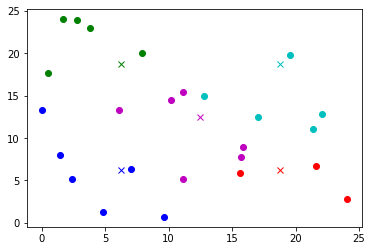

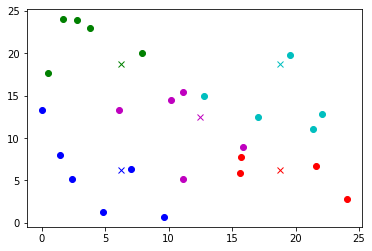

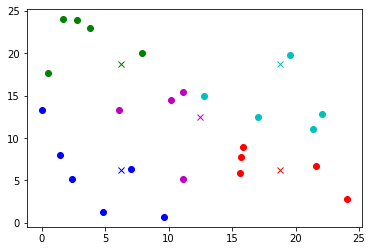

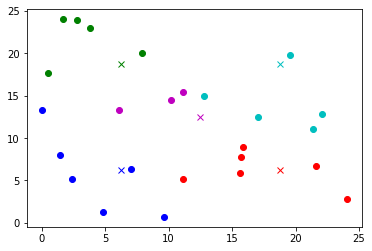

Step2 LSA to Radial End
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


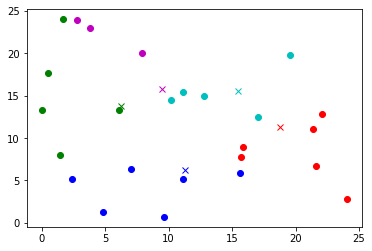

Step3 Radial to Radial
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


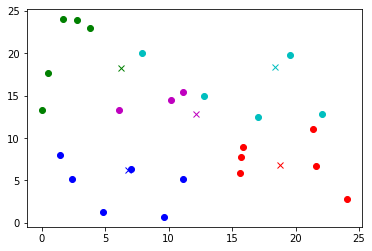

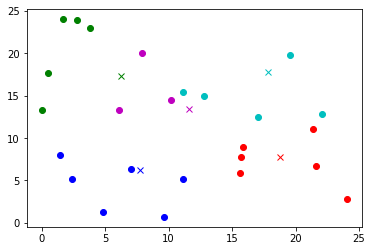

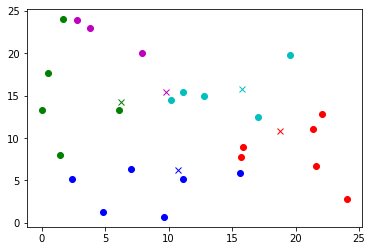

RR average run time
0.6253423690795898
average steps computing RR breakpoints
4
average time to compute LRStart
0.8646640777587891
average steps computing LRStart
0
average time to compute LREnd
0
average steps computing LREnd
0
the average iters for R2R is 52.5 and the average model run time was 0.0007467269897460938


In [13]:
#Executable code

# for the graph plotting please do not change this value. This value can be 5 or 10 in the serarate scripts
k = 5

#this value can be either 25 or 50 when k = 5 and it can only be 200 when k = 10
n = 25

# if n = 25 set this to 3 and 7. if n= 50 use 8 and 12. Lastly if n = 200 use 16 and 24
small = 3
big = 7

#these are just setting up the run information
epsilon = 1.1
timeSumRR = 0
stepSumRR = 0
timeSumLRStart = 0
stepSumLRStart = 0
timeSumRLEnd = 0
stepSumRLEnd = 0
sliceSteps = 0
diffCount = 0

start, end, points, upperBounds, lowerBounds, startBound, endBound = setUpCluster( k, n, small, big)

sAssignmentLSA, sAssignmentRad, sAssignmentVect, eAssignmentLSA, eAssignmentRad, eAssignmentVect = startingClusters(start, end, points, upperBounds, 
                                                                                     lowerBounds, startBound, endBound)

print("the number of points that change are  " + str(diffCounter(sAssignmentLSA, eAssignmentLSA)))
diffCount += diffCounter(sAssignmentLSA, eAssignmentLSA)
print("Step1 LSA to Radial Start")
IterCountStart, LSAStartTime, LSAStartEndTime, usable = LSA2Radial(k,n,start, points, upperBounds, lowerBounds, startBound, sAssignmentLSA, sAssignmentRad)


timeSumLRStart += LSAStartTime
stepSumLRStart += IterCountStart
print("Step2 LSA to Radial End")
IterCountEnd, LSAEndTime, LSAEndEndTime, usable = LSA2Radial(k,n,end, points, upperBounds, lowerBounds, endBound, eAssignmentLSA, eAssignmentRad)
print("Step3 Radial to Radial")
stepCountRadial, totalTimeRRStep, avgRRIters, avgRRRunTime = Radial2Radial(start, end, points, upperBounds,
                                 lowerBounds,epsilon)
timeSumRR += totalTimeRRStep
stepSumRR += stepCountRadial
timeSumLRStart += LSAStartTime
stepSumLRStart += IterCountStart
timeSumRLEnd += LSAEndTime
stepSumRLEnd += IterCountEnd

    
print("RR average run time")
print(timeSumRR)
print("average steps computing RR breakpoints")
print(stepSumRR)
print("average time to compute LRStart")
print(timeSumLRStart)
print("average steps computing LRStart")
print(stepSumLRStart)
print("average time to compute LREnd")
print(timeSumRLEnd)
print("average steps computing LREnd")
print(stepSumRLEnd)
print("the average iters for R2R is " + str(avgRRIters) + " and the average model run time was " + str(avgRRRunTime))